In [1]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
import scipy.special
import sklearn.metrics
import seaborn as sns
sns.set()
import numpy as np
import os
import glob
import pandas as pd
from PIL import Image
import sys
sys.path.append("..")
from src.datamodule.DataLoader import PlanktonDataLoader
import hydra
from src.lib.config import Config, register_configs
from src.models.LightningBaseModel import LightningModel
from src.utils.utils import print_config
from src.utils.CustomMetrics import MultiLabelAccuracy
register_configs()
try:
    hydra.initialize(config_path="../conf", job_name="plankton")
except ValueError:
    print(ValueError)
    
import pytorch_lightning as pl
from natsort import natsorted

In [2]:
# set global values:

# onnx_experiments = {
#     "supervised_singlelabel": "/gpfs/work/machnitz/plankton_logs/supervised/singlelabel/multirun/2022-04-15/08-16-27",
#     "supervised_multilabel": "/gpfs/work/machnitz/plankton_logs/supervised/multilabel/multirun/2022-04-19/07-12-05",
#     "finetune_singlelabel": "/gpfs/work/machnitz/plankton_logs/finetune/singlelabel/multirun/2022-04-15/16-25-32",
#     "finetune_multilabel": "/gpfs/work/machnitz/plankton_logs/finetune/multilabel/multirun/2022-04-15/11-16-50",
#     "linear_singlelabel": "/gpfs/work/machnitz/plankton_logs/linear_eval/singlelabel/multirun/2022-04-15/16-13-23",
#     "linear_multilabel": "/gpfs/work/machnitz/plankton_logs/linear_eval/multilabel/multirun/2022-04-15/14-53-03 "
# }

experiments = {
    "supervised_multilabel": "/gpfs/work/machnitz/plankton_logs/supervised/multilabel/multirun/2022-04-19/08-13-41",
    "linear_multilabel": "/gpfs/work/machnitz/plankton_logs/linear_eval/multilabel/multirun/2022-04-19/08-14-01",
    "finetune_multilabel": "/gpfs/work/machnitz/plankton_logs/finetune/multilabel/multirun/2022-04-19/08-14-27",
    "finetune_sgd_multilabel": "/gpfs/work/machnitz/plankton_logs/finetune_sgd/multilabel/multirun/2022-04-19/14-06-46"
}

data_splits_per_experiment = [np.round(x,2) for x in np.arange(0.01, 0.1, 0.01)] + [np.round(x, 2) for x in np.arange(0.1, 1.1, 0.1)]
print("Data splits: ", data_splits_per_experiment)

Data splits:  [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


In [3]:
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set()

hereon_color_array = np.array([
    [230, 0, 70],
    [0,145,160],
    [0, 170, 230],
    [250,180,35],
    [0,70,125],
    [175, 25, 60],
    [170, 200 ,70],
    [250,115,80],
    [140, 90, 180],
      
])
hereon_color_array = hereon_color_array / 255
hereon_cmap = ListedColormap(hereon_color_array)

sns.set_palette(hereon_color_array)

# Multi Label experiments

We only need to load the config of the supervised run, since it only is used to init the data-loaders and they are the same for all single-label experiments.

In [4]:
pl.seed_everything(7)
np.random.seed(7)
cfg = hydra.compose(config_name="config", overrides=["+experiment=plankton/publication/supervised_multilabel", 
                                                     "random_seed=7", 
                                                     "strategy=SingleDevice", 
                                                     'strategy.device="cuda:0"', 
                                                     "trainer.enable_progress_bar=false",
                                                     "datamodule.batch_size=200"])

Global seed set to 7


In [5]:
train_transforms = hydra.utils.instantiate(cfg.datamodule.train_transforms)
valid_transforms = hydra.utils.instantiate(cfg.datamodule.valid_transforms)

datamodule = hydra.utils.instantiate(
    cfg.datamodule,
    train_transforms=train_transforms,
    valid_transforms=valid_transforms,
    dataset=cfg.datamodule.dataset,
    is_ddp=False,
)
datamodule.setup(stage="test")

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:95: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


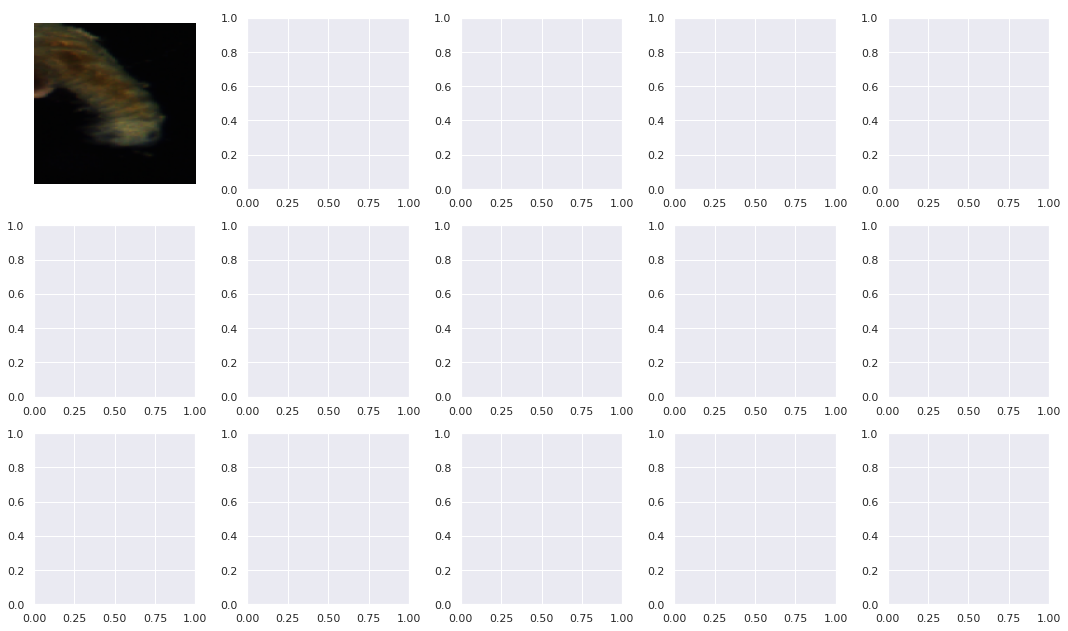

In [6]:
fig, axes = plt.subplots(ncols=5, nrows=3, figsize=(15,9))
dataloader = datamodule.test_dataloader()

for i, batch in enumerate(dataloader):
    ax = axes.flatten()[i]
    example_input, label = batch
    example_input = example_input.cpu().numpy()
    ax.imshow(np.moveaxis(example_input[0], 0, -1))
    ax.grid(False)
    ax.set_axis_off()
    ax.set_title(label[-1][0], color="white")
    if i >=14:
        break

plt.tight_layout()
plt.savefig("example_images_raw.png", dpi=600, transparent=True)

In [7]:
def get_confidence_and_acc(logits, labels, acc_func=MultiLabelAccuracy(weighted=True), n_bins=15):
    ece = torch.zeros(1, device=logits.device)
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    softmaxes = F.softmax(logits, dim=1)
    confidences, predictions = torch.max(softmaxes, 1)
    accuracies = torch.tensor([acc_func(predictions=prediction.unsqueeze(0), 
                                            targets=label.unsqueeze(0), 
                                            n_labels=labels.max()+1) 
                               for prediction, label in zip(predictions, labels)])
    accuracy_bins = []
    confidence_bins = []
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated in each bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()
        if prop_in_bin.item() > 0:
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            accuracy_bins.append(accuracy_in_bin)
            confidence_bins.append(avg_confidence_in_bin)
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    return torch.tensor(accuracy_bins), torch.tensor(confidence_bins), ece.item()
    

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


  0%|          | 0/19 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.17749999463558197    │
│       loss/Testing        │    2.8251941204071045     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.4749999940395355     │
│       loss/Testing        │    2.2091434001922607     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.4650000035762787     │
│       loss/Testing        │    1.6161807775497437     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.38499999046325684    │
│       loss/Testing        │     1.455483078956604     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.44999998807907104    │
│       loss/Testing        │    1.4184199571609497     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5324999690055847     │
│       loss/Testing        │    1.2952266931533813     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5550000071525574     │
│       loss/Testing        │     1.316196084022522     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5099999904632568     │
│       loss/Testing        │     1.297329306602478     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5199999809265137     │
│       loss/Testing        │    1.3041834831237793     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.4699999988079071     │
│       loss/Testing        │    1.4901986122131348     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.48500001430511475    │
│       loss/Testing        │     1.365912675857544     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.4699999988079071     │
│       loss/Testing        │    1.4370031356811523     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.4699999988079071     │
│       loss/Testing        │    1.3171979188919067     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5475000143051147     │
│       loss/Testing        │    1.2774837017059326     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5049999952316284     │
│       loss/Testing        │     1.299687147140503     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.47749999165534973    │
│       loss/Testing        │    1.3113141059875488     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5349999666213989     │
│       loss/Testing        │    1.2889126539230347     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5475000143051147     │
│       loss/Testing        │    1.2263271808624268     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5475000143051147     │
│       loss/Testing        │    1.2496579885482788     │
└───────────────────────────┴───────────────────────────┘

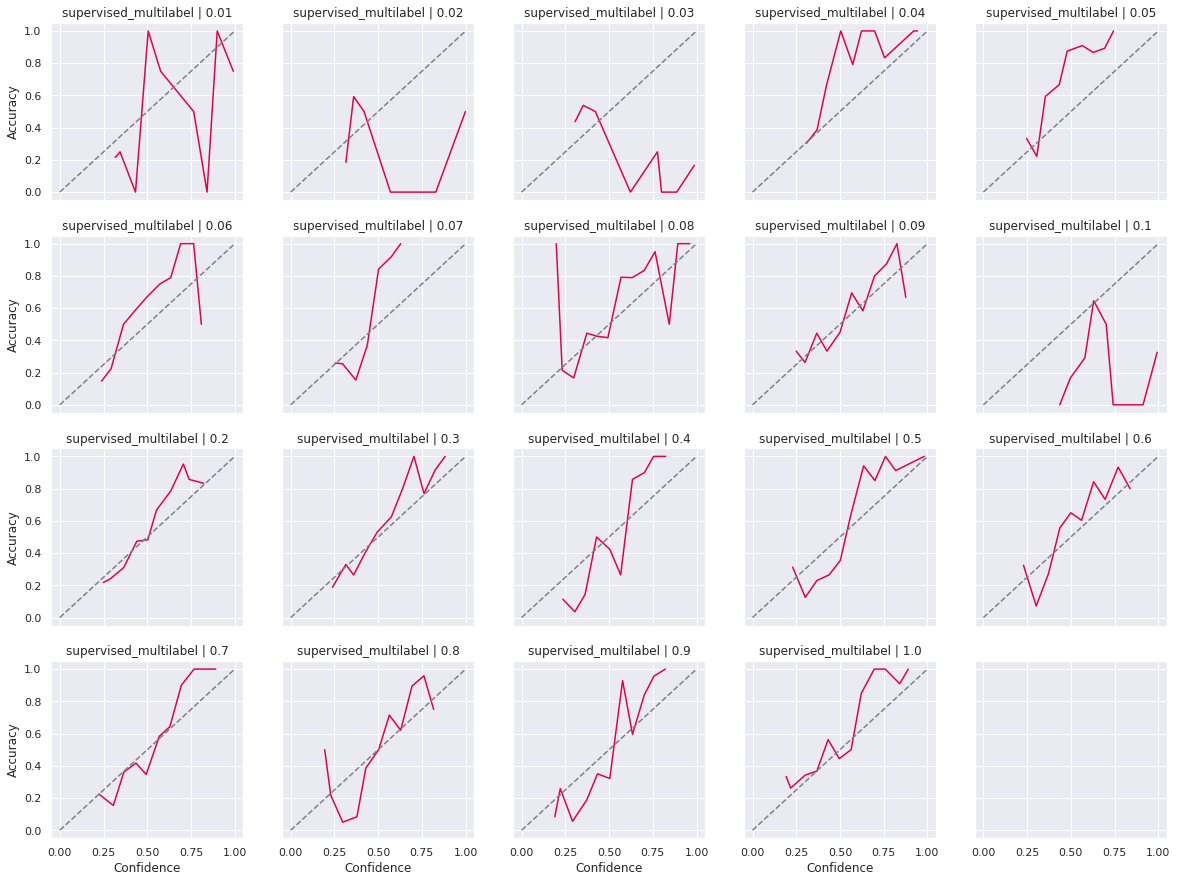

  0%|          | 0/19 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.1850000023841858     │
│       loss/Testing        │    1.8465607166290283     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5099999904632568     │
│       loss/Testing        │    1.5244321823120117     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.4924999475479126     │
│       loss/Testing        │    1.4643347263336182     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5024999976158142     │
│       loss/Testing        │    1.2264065742492676     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │     0.512499988079071     │
│       loss/Testing        │     1.190900444984436     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.6349999904632568     │
│       loss/Testing        │     1.05241858959198      │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.6899999976158142     │
│       loss/Testing        │    0.8198291063308716     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.6949999928474426     │
│       loss/Testing        │     0.825751781463623     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.7099999785423279     │
│       loss/Testing        │    0.8375001549720764     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.7475000023841858     │
│       loss/Testing        │     0.823840856552124     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.7475000023841858     │
│       loss/Testing        │    0.6623733639717102     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.7900000214576721     │
│       loss/Testing        │    0.5944664478302002     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8199999928474426     │
│       loss/Testing        │    0.5434028506278992     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │          0.8125           │
│       loss/Testing        │    0.5341919660568237     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.7900000214576721     │
│       loss/Testing        │    0.5517359375953674     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8224999904632568     │
│       loss/Testing        │    0.5378338694572449     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │     0.824999988079071     │
│       loss/Testing        │    0.5369042158126831     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8149999976158142     │
│       loss/Testing        │    0.5349498391151428     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8174999952316284     │
│       loss/Testing        │    0.5445429682731628     │
└───────────────────────────┴───────────────────────────┘

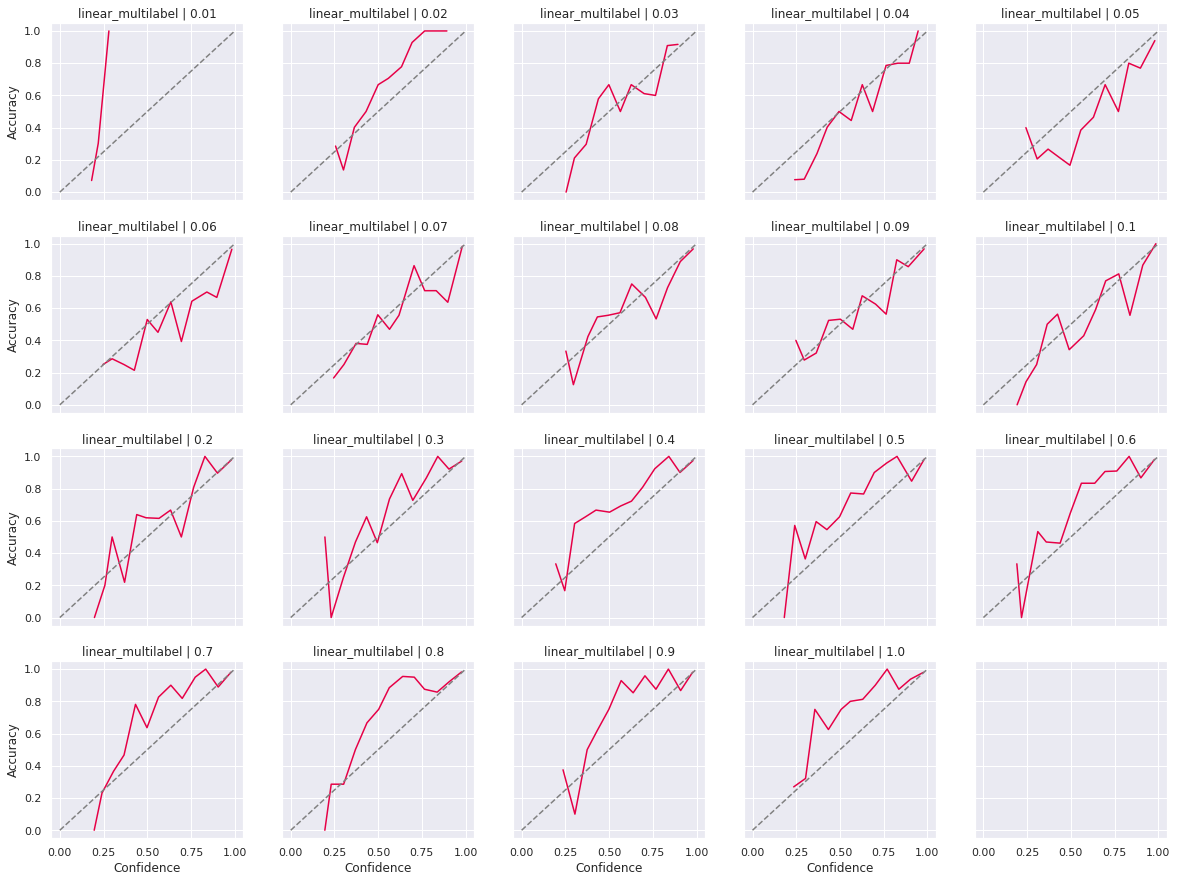

  0%|          | 0/19 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.13750000298023224    │
│       loss/Testing        │     2.679344415664673     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.4949999749660492     │
│       loss/Testing        │     2.93588924407959      │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5724999904632568     │
│       loss/Testing        │    1.3620296716690063     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5874999761581421     │
│       loss/Testing        │     1.293154239654541     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5349999666213989     │
│       loss/Testing        │    1.2445740699768066     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5374999642372131     │
│       loss/Testing        │    1.3122799396514893     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5824999809265137     │
│       loss/Testing        │    1.2644187211990356     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │          0.5625           │
│       loss/Testing        │    1.0899972915649414     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5824999809265137     │
│       loss/Testing        │    1.1246908903121948     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5399999618530273     │
│       loss/Testing        │    1.2135010957717896     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5299999713897705     │
│       loss/Testing        │    1.1777288913726807     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5824999809265137     │
│       loss/Testing        │     1.143331527709961     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.7099999785423279     │
│       loss/Testing        │    0.9363468885421753     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.6625000238418579     │
│       loss/Testing        │     1.010257363319397     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.6299999952316284     │
│       loss/Testing        │    0.9862053394317627     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5999999642372131     │
│       loss/Testing        │    1.0557122230529785     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5724999904632568     │
│       loss/Testing        │    1.0662301778793335     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5799999833106995     │
│       loss/Testing        │    0.9778544902801514     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.6600000262260437     │
│       loss/Testing        │    0.9610252380371094     │
└───────────────────────────┴───────────────────────────┘

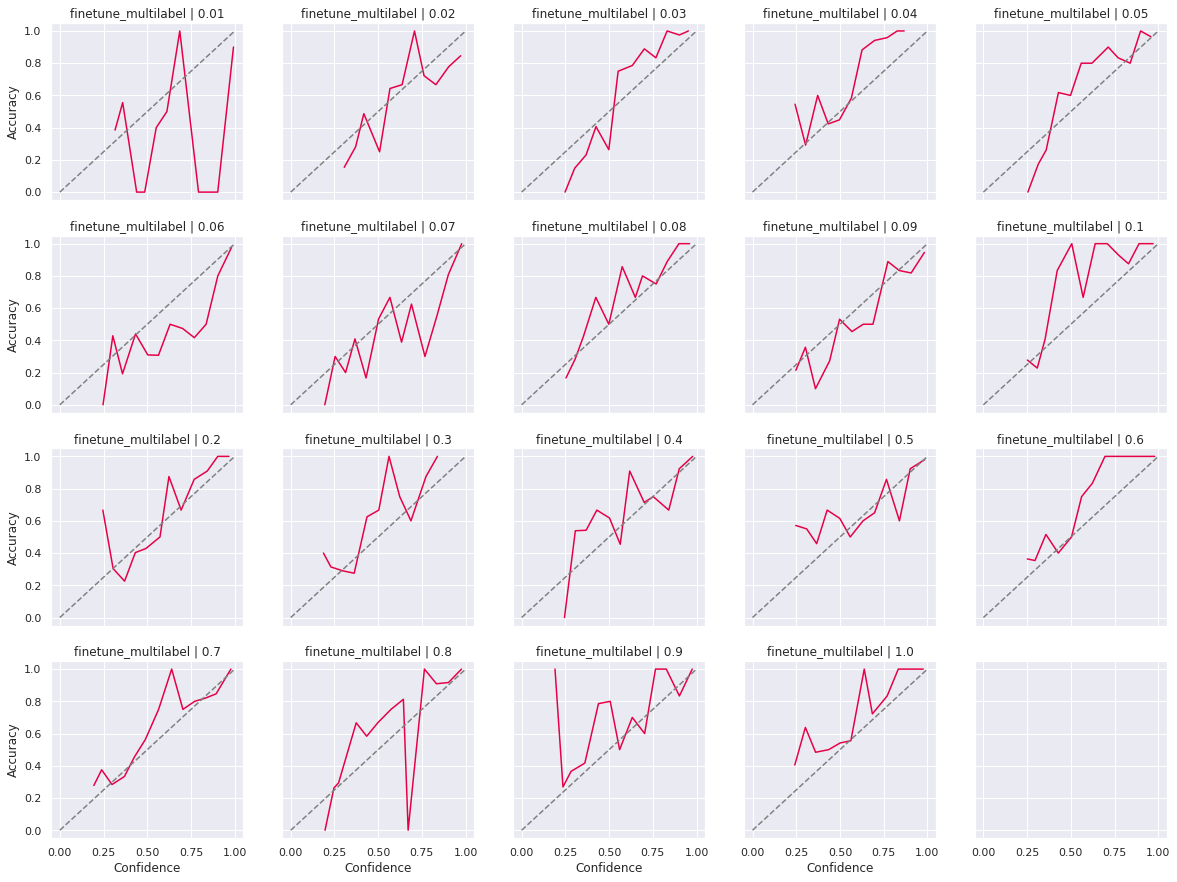

  0%|          | 0/19 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.19750000536441803    │
│       loss/Testing        │    1.8380770683288574     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5274999737739563     │
│       loss/Testing        │     1.544100284576416     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │     0.512499988079071     │
│       loss/Testing        │    1.4264224767684937     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5475000143051147     │
│       loss/Testing        │    1.1634670495986938     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.5924999713897705     │
│       loss/Testing        │    1.0843605995178223     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.7074999809265137     │
│       loss/Testing        │    0.9081857204437256     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.7074999809265137     │
│       loss/Testing        │    0.8359697461128235     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8274999856948853     │
│       loss/Testing        │    1.0551594495773315     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.7825000286102295     │
│       loss/Testing        │    0.8989417552947998     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.6549999713897705     │
│       loss/Testing        │    1.0987673997879028     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.7999999523162842     │
│       loss/Testing        │    0.6520363092422485     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8349999785423279     │
│       loss/Testing        │    0.5562929511070251     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8599998950958252     │
│       loss/Testing        │    0.5573161244392395     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8624999523162842     │
│       loss/Testing        │    0.48871466517448425    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8324999809265137     │
│       loss/Testing        │    0.6181886792182922     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8450000286102295     │
│       loss/Testing        │    0.45700687170028687    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8599998950958252     │
│       loss/Testing        │    0.37826186418533325    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8849999904632568     │
│       loss/Testing        │    0.43571653962135315    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Accuracy/Testing      │    0.8700000047683716     │
│       loss/Testing        │     0.463684618473053     │
└───────────────────────────┴───────────────────────────┘

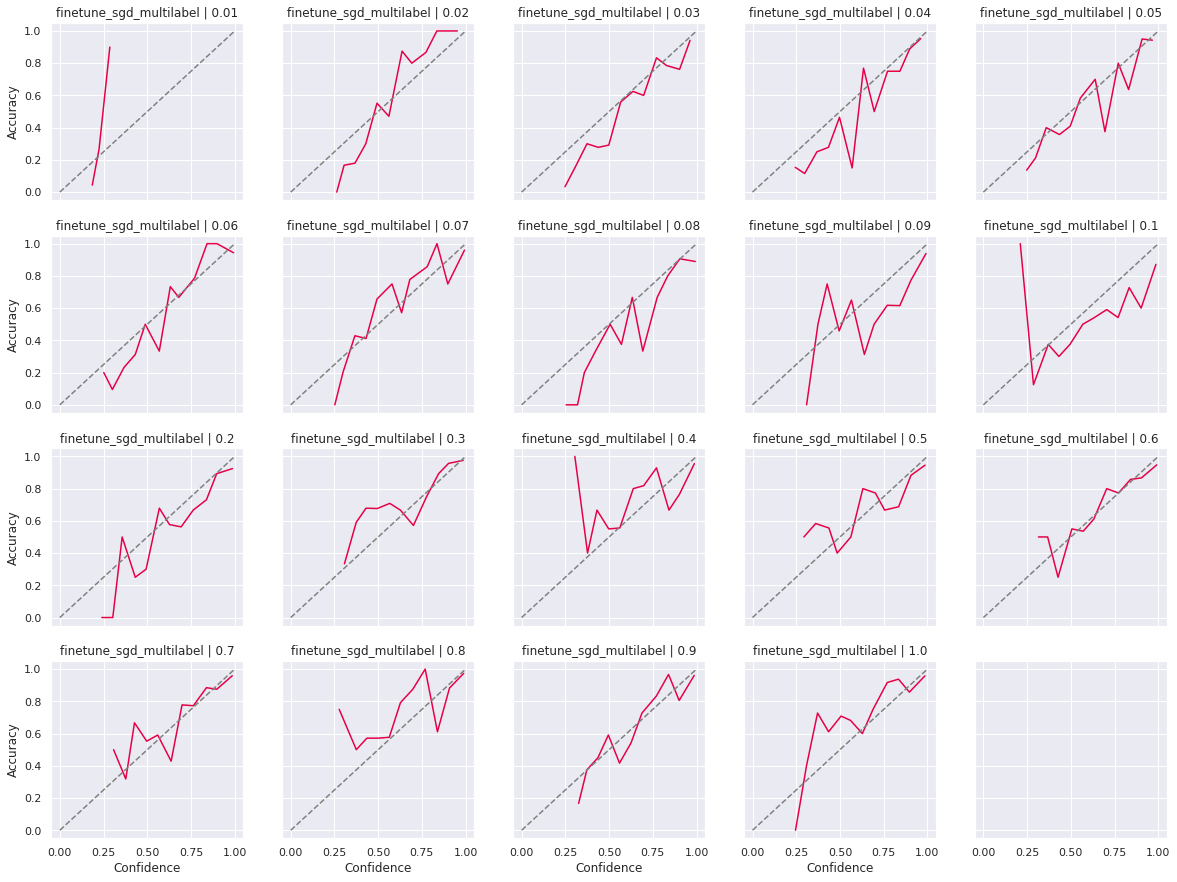

In [14]:
def instantiate_model(ckpt_path):
    model = LightningModel.load_from_checkpoint(checkpoint_path=ckpt_path)
    model.set_external_data(
            class_labels=datamodule.unique_labels,
            all_labels=datamodule.all_labels,
            example_input_array=torch.tensor(example_input).detach().cpu(),
        )
    return model
    
def instantiate_trainer():
    trainer: Trainer = hydra.utils.instantiate(
            cfg.trainer,
            strategy=cfg.strategy,
            logger=[],
            callbacks=[],
            _convert_="partial",
            profiler=None,
        )
    return trainer

trainer = instantiate_trainer()

    
return_metrics = dict()
for key, setup_path in experiments.items():
    experiment_folders = [os.path.join(setup_path, str(i)) for i in np.arange(0, 19)]
    return_metrics[key] = dict()
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20,15), sharex=True, sharey=True)
    for experiment_number, experiment_path in enumerate(tqdm(experiment_folders)):
        # print(experiment_number)
        with open(os.path.join(experiment_path, "main.log"), "r") as f:
            complete_log = f.readlines()
            found_best_checkpoint = False
            for line in complete_log:
                # print(line)
                if found_best_checkpoint:
                    best_checkpoint = line.strip()
                    # print(f"set best checkpoint to {best_checkpoint}")
                    break
                    
                if "[main.main][INFO] - Best checkpoint path:" in line:
                    found_best_checkpoint = True
                    # print(f"found best checkpoint: {line}")
            
        model = instantiate_model(best_checkpoint)
        return_metrics[key][experiment_number] = trainer.test(model, dataloader)[0]
        return_metrics[key][experiment_number]["Data Fraction"] = data_splits_per_experiment[experiment_number]
        
        with torch.no_grad():
            for batch in dataloader:
                x, labels = batch
                logits = model(x)[1]
                
                accuracies, confidences, ece = get_confidence_and_acc(logits, labels[1])
                return_metrics[key][experiment_number]["ECE"] = ece
        
        ax = axes.flatten()[experiment_number]
        sns.lineplot(x=confidences.cpu().numpy(), y=accuracies.cpu().numpy(), ax=ax)
        ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), c="grey", ls="--")
        ax.set_xlabel("Confidence")
        ax.set_ylabel("Accuracy")
        ax.set_title(f"{key} | {data_splits_per_experiment[experiment_number]}")
        del model
    plt.show()
    plt.close("all")

In [15]:
confidences

tensor([0.2459, 0.3087, 0.3719, 0.4350, 0.5061, 0.5602, 0.6281, 0.6889, 0.7701,
        0.8347, 0.8968, 0.9856])

In [16]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in return_metrics.items() for innerKey, values in innerDict.items()}
multi_label_df = pd.DataFrame.from_dict(reform).T
multi_label_df.index.names = ("Model", "Experiment")
multi_label_df

loss/Testing  Accuracy/Testing  \
Model                   Experiment                                   
supervised_multilabel   0               2.825194            0.1775   
                        1               2.209143            0.4750   
                        2               1.616181            0.4650   
                        3               1.455483            0.3850   
                        4               1.418420            0.4500   
...                                          ...               ...   
finetune_sgd_multilabel 14              0.618189            0.8325   
                        15              0.457007            0.8450   
                        16              0.378262            0.8600   
                        17              0.435717            0.8850   
                        18              0.463685            0.8700   

                                    Data Fraction       ECE  
Model                   Experiment                           
supervised_multilabel   0                    0.01  0.119479  
                        1                    0.02  0.217853  
                        2                    0.03  0.166294  
                        3                    0.04  0.089088  
                        4                    0.05  0.180400  
...                                           ...       ...  
finetune_sgd_multilabel 14                   0.60  0.053206  
                        15                   0.70  0.050836  
                        16                   0.80  0.070348  
                        17                   0.90  0.053881  
                        18                   1.00  0.083004  

[76 rows x 4 columns]

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


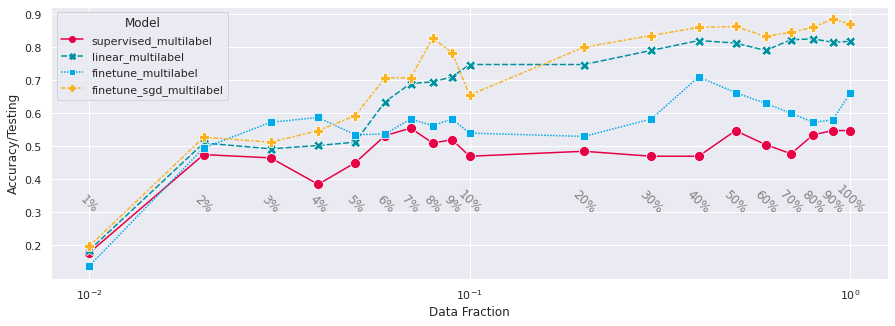

In [25]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x="Data Fraction", y="Accuracy/Testing", hue="Model", style="Model", data=multi_label_df, ax=ax, palette=hereon_color_array,  markers=True, markersize=10,)

for item in data_splits_per_experiment:
    ax.text(item,0.3,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
plt.savefig("Accuracies_Testing_Multilabel.png", dpi=300)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


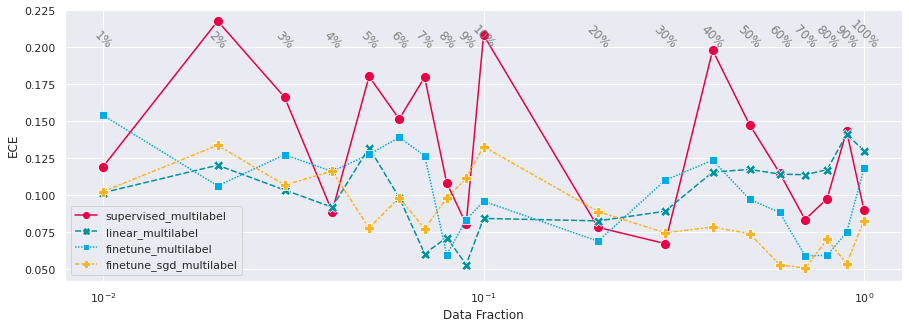

In [26]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x="Data Fraction", y="ECE", hue="Model", style="Model", data=multi_label_df, ax=ax, palette=hereon_color_array,  markers=True, markersize=10,)

for item in data_splits_per_experiment:
    ax.text(item,0.2,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
ax.legend(loc="best")
plt.savefig("ECE_Testing_Multilabel.png", dpi=300)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


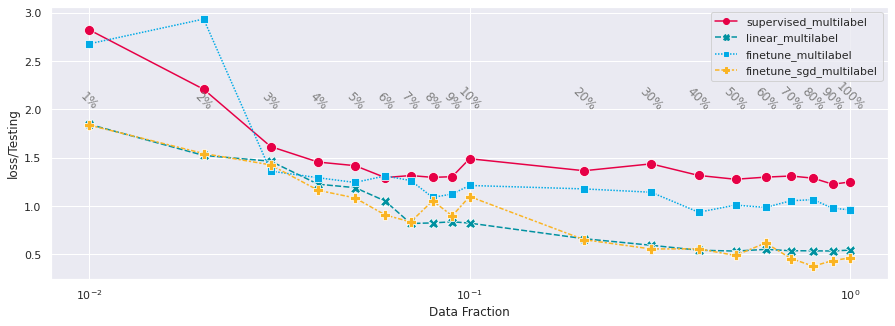

In [27]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x="Data Fraction", y="loss/Testing", hue="Model", style="Model", data=multi_label_df, ax=ax, palette=hereon_color_array,  markers=True, markersize=10,)

for item in data_splits_per_experiment:
    ax.text(item,2,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
ax.legend(loc="best")
plt.savefig("KLDiv_Testing_Multilabel.png", dpi=300)

# Single Label

In [ ]:
for key, setup_path in onnx_experiments.items():
    experiment_folders = [os.path.join(setup_path, str(i)) for i in np.arange(0, 19)]
    for experiment_number, experiment_path in enumerate(experiment_folders):
        print(experiment_number)
        with open(os.path.join(experiment_path, "main.log"), "r") as f:
            complete_log = f.readlines()
            found_best_checkpoint = False
            for line in complete_log:
                # print(line)
                if found_best_checkpoint:
                    best_checkpoint = line.lstrip()
                    print(f"set best checkpoint to {best_checkpoint}")
                    break
                    
                if "[main.main][INFO] - Best checkpoint path:" in line:
                    found_best_checkpoint = True
                    print(f"found best checkpoint: {line}")

        print(f"best_checkpoint: {best_checkpoint}")
        if "last.ckpt" in best_checkpoint:
            onnx_file = natsorted(glob.glob(os.path.join(os.path.split(best_checkpoint)[0], "*.onnx")))[-1]
        else:
            onnx_file = best_checkpoint.replace("epoch=", "model_").replace(".ckpt", ".onnx")
            
        onnx_file = onnx_file.strip()
            
        print(f"Onnx file: {onnx_file}")
        # options = ort.SessionOptions()
        # options.inter_op_num_threads = 1
        # options.intra_op_num_threads = 1

        ort_sess = ort.InferenceSession(onnx_file, providers=providers)
        ort_sess.get_inputs()[0].name#

        # make some prediction from the loaded onnx model:

        input_name = ort_sess.get_inputs()[0].name
        output_name = ort_sess.get_outputs()[0].name

        predicted_probabilities = np.empty(shape=(len(dataloader.dataset), ort_sess.get_outputs()[0].shape[1]))
        targets = np.empty(shape=(len(dataloader.dataset), 1))
        predicted_labels = np.empty_like(targets)
        counter = 0
        for batch in tqdm(dataloader, total=len(dataloader)):
            x, y = batch
            predicted_probabilities[counter : counter + x.shape[0]] = ort_sess.run([output_name], {input_name: x.cpu().numpy()})[0]
            predicted_labels = scipy.special.softmax(predicted_probabilities, axis=1).argmax(axis=1)
            targets[counter : counter + x.shape[0]] = y[1]
            counter += x.shape[0]
        print(f"{key}, experiment {experiment_number}: {sklearn.metrics.accuracy_score(y_true=targets, y_pred=predicted_labels)}")
        del ort_session